source: https://towardsdatascience.com/mnist-cnn-python-c61a5bce7a19

# Title

In [1]:
# Import modules
import numpy as np
import pandas as pd
import struct
import gzip
import tensorflow as tf
from matplotlib import pyplot as plt

## Import data

All resources is found in zipped / unzipped. We can read zipped files directly or unzip them first, then read them.

In [98]:
# Train images
with gzip.open('zipped/train-images-idx3-ubyte.gz','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    train_X = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
    train_X = train_X.reshape((size, nrows, ncols))

# Train labels
with open('unzipped/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    train_y = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    train_y = train_y.reshape((size,)) # (Optional)

In [99]:
# Test images
with gzip.open('zipped/t10k-images-idx3-ubyte.gz','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    test_X = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
    test_X = test_X.reshape((size, nrows, ncols))
    
# Train labels
with open('unzipped/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    test_y = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    test_y = test_y.reshape((size,)) # (Optional)

## Visualise the data

Now that we have the data in memory, we should look at it. See if everything is correct, and see if there are any interesting features in the dataset.

First I would like to view how big the data set is:

In [100]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test: ' + str(test_X.shape))
print('Y_test: ' + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test: (10000, 28, 28)
Y_test: (10000,)


From the output above we can see that the train set contains of 60000 rows with 28 * 28 features. That is 28 * 28 pixels representing a handwritten number. Each pixels is then a number between 0-255 to represent the grey-scale of that particular pixel. There are also 600000 labels, with a number between 0-9 that tells which number is drawn in each picture.

The test set is 1/6 the size of the train set with 10000 rows, each row has 28 * 28 features (again 28 * 28 pixels) and one label with a number between 0-9.

Next, we plot some of the images to see what we're working with:

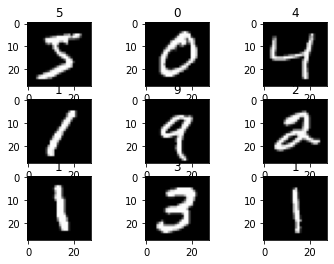

In [101]:
# Plot the first 9 numbers of the train set
for i in range(9):
  subplot = plt.subplot(330 + 1 + i)
  subplot.set_title(train_y[i])
  plt.imshow(train_X[i], cmap='gray')
plt.show()

# Split into 3 local section

Tasked to split the data set into 3 local section. Train a model for each section, then combine them to a global model. Therefore we must split the data into three section:

- One for digits 0-2
- One for digits 3-5
- One for digits 6-9

In [106]:
def split_into_section(features, labels, lower_boud, upper_boud):
  new_features = []
  new_labels = []
  
  for i in range(len(features)):
    if lower_boud <= labels[i] <= upper_boud:
      new_features.append(features[i])
      new_labels.append(labels[i])

  return new_features, new_labels

In [108]:
train_X_group_one, train_y_group_one = split_into_section(train_X, train_y, 0, 2)
train_X_group_two, train_y_group_two = split_into_section(train_X, train_y, 3, 5)
train_X_group_three, train_y_group_three = split_into_section(train_X, train_y, 6, 9)

test_X_group_one, test_y_group_one = split_into_section(test_X, test_y, 0, 2)
test_X_group_two, test_y_group_two = split_into_section(test_X, test_y, 3, 5)
test_X_group_three, test_y_group_three = split_into_section(test_X, test_y, 6, 9)

Next I want to verify that I split the section correct, so I print out the first 9 images of each section:

Group 1 (0-2)


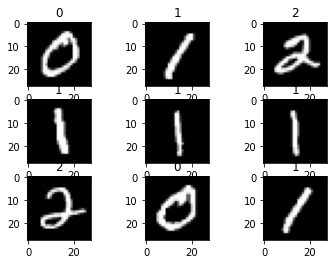

Group 2 (3-5)


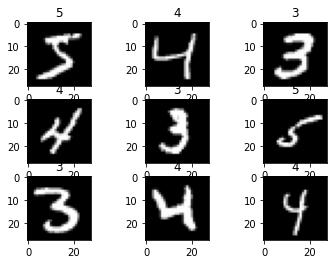

Group 3 (6-9)


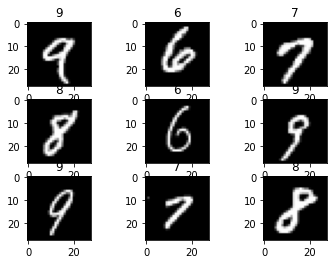

In [109]:
print("Group 1 (0-2)")
for i in range(9):
  subplot = plt.subplot(330 + 1 + i)
  subplot.set_title(train_y_group_one[i])
  plt.imshow(train_X_group_one[i], cmap='gray')
plt.show()

print("Group 2 (3-5)")
for i in range(9):
  subplot = plt.subplot(330 + 1 + i)
  subplot.set_title(train_y_group_two[i])
  plt.imshow(train_X_group_two[i], cmap='gray')
plt.show()

print("Group 3 (6-9)")
for i in range(9):
  subplot = plt.subplot(330 + 1 + i)
  subplot.set_title(train_y_group_three[i])
  plt.imshow(train_X_group_three[i], cmap='gray')
plt.show()

## Preprocess the data

In [110]:
train_X_group_one = np.array(train_X_group_one).reshape(-1, 28,28, 1)
test_X_group_one = np.array(test_X_group_one).reshape(-1, 28,28, 1)

In [111]:
train_X_group_one = train_X_group_one.astype('float32')
test_X_group_one = test_X_group_one.astype('float32')

train_X_group_one = train_X_group_one / 255
test_X_group_one = test_X_group_one / 255

In [114]:
train_y_group_one_one_hot = tf.keras.utils.to_categorical(train_y_group_one)
test_y_group_one_one_hot = tf.keras.utils.to_categorical(train_y_group_one)